# Parte 1

In [1]:

using Optim

# Parámetros del modelo
β = 0.95  # Factor de descuento
δ = 0.1   # Tasa de depreciación del capital
α = 0.3   # Elasticidad de producción con respecto al capital
k0 = 10   # Capital inicial
T = 100   # Número de periodos
kopt = 100  # Capital óptimo de estado estacionario

# Factor de escala de la función de producción, calculado para el estado estacionario óptimo
A = ((1/β)-(1-δ))/(α*kopt^(α-1))
            
# Función de utilidad
u(c) = log(c)

# Derivada de la función de utilidad
u_prime(c) = 1/c

# Inversa de la derivada de la función de utilidad
u_prime_inv(c) = 1/c

# Función de producción
function F(k, A = A, α = α)
    if k > 0
        return A * k^α
    else
        return 0
    end
end

# Derivada de la función de producción
function F_prime(k, A = A, α = α) 
    if k < 0
        return 0
    else
        return A * α * k^(α-1)
    end
end

# Función de producción con depreciación
function f(k, A = A, α = α, δ = δ)
    if k > 0
        return F(k) + (1 - δ) * k
    else
        return 0
    end
end

# Derivada de la función de producción con depreciación
function f_prime(k, A = A, α = α, δ = δ) 
    if k < 0
        return 0
    else
        return F_prime(k) + (1 - δ)
    end
end

# Computa el siguiente capital y consumo basado en los valores actuales
function next_k_c(k, c, A = A, α = α, δ = δ, β = β)
    k_next = f(k) - c
    c_next = u_prime_inv(u_prime(c) / (β * (f_prime(k_next))))
    return k_next, c_next
end

# Algoritmo de shooting para encontrar la trayectoria óptima de capital y consumo
function shooting(k0, c0, T, A = A, α = α, δ = δ, β = β; verbose = false)
    # Inicializar vectores para almacenar las trayectorias de capital y consumo
    k_vec = zeros(T+2)
    c_vec = zeros(T+1)
    
    k_vec[1] = k0
    c_vec[1] = c0

    # Iterar sobre los periodos para calcular las trayectorias
    for t in 1:T
        k_vec[t+1], c_vec[t+1] = next_k_c(k_vec[t], c_vec[t], A, α, δ, β)
        if verbose
            println("$t : k = $(k_vec[t+1]), c = $(c_vec[t+1])")
        end
    end

    # Calcular el capital final
    k_vec[T+2] = f(k_vec[T+1]) + (1 - δ) * k_vec[T+1] - c_vec[T+1]

    return [k_vec, c_vec]
end;

# Valores iniciales y parámetros para el shooting
c0_lo = 0.0   # mínimo: no hay consumo
c0_hi = f(k0) # máximo: no hay ahorro

c0 = (c0_lo + c0_hi) / 2 # Adivinanza inicial: punto medio

maxiter = 10e5           # Máximo número de iteraciones para evitar bucles infinitos
tol = 10e-13             # Tolerancia para la solución

i = 0
while i < maxiter
    c0 = (c0_lo + c0_hi) / 2     # Actualizar adivinanza
    k,c = shooting(k0, c0, 100)  # Calcular las trayectorias de k y c basado en la adivinanza actual

    # Verificar si el capital final está cerca de cero o si la tolerancia se ha alcanzado
    if k[end] ≈ 0 || (c0_hi - c0_lo) / 2 < tol
        println("Solución: c0 = $(c0)")
        break
    # Ajustar el intervalo de búsqueda de c0 según el signo del capital final
    elseif k[end] > 0
        c0_lo = c0
    else
        c0_hi = c0
    end

    i += 1
end
c0_optim = c0;

# Calcular las trayectorias óptimas con el consumo inicial óptimo c0
k_opt, c_opt = shooting(k0, c0_optim, T)
println("Consumo inicial óptimo (c0): ", c0_optim)
println("Trayectoria óptima de capital: ", k_opt)
println("Trayectoria óptima de consumo: ", c_opt)



Solución: c0 = 14.690856448783084
Consumo inicial óptimo (c0): 14.690856448783084
Trayectoria óptima de capital: [10.0, 19.80814315681496, 29.952506648859565, 39.5313137089304, 48.195497037104445, 55.84844131732096, 62.510484481223926, 68.2546103916354, 73.17449370093154, 77.36828387338824, 80.9304664779002, 83.94801899895087, 86.49889020538753, 88.65173421843392, 90.46630352126681, 91.99416364644502, 93.27953800810809, 94.36017538525985, 95.26818173075416, 96.03078692231432, 96.6710340494165, 97.20838863310695, 97.65927064381418, 98.03751502729278, 98.35476771730494, 98.62082445035448, 98.84391950172355, 99.03097097974262, 99.18778869778355, 99.31924998201058, 99.4294481207455, 99.52181754791758, 99.5992392931792, 99.66412973048872, 99.7185152154796, 99.76409481684559, 99.80229301375815, 99.83430394477423, 99.86112854844149, 99.88360572669501, 99.90243848437055, 99.9182158473812, 99.93143123444949, 99.94249784934306, 99.95176156936145, 99.95951172878867, 99.96599013094223, 99.97139856

# Parte 2

Maximizar

$$
\sum_{t=0}^{\infty} \beta^t \log(c_t)
$$

sujeto a

$$
c_t + k_{t+1} - (1 - \delta)k_t = A k_t^\alpha
$$

y

$$
k_0 > 0
$$

# B)

In [3]:
using Plots

# Parámetros del modelo
β = 0.96           # Factor de descuento
A = 1.0            # Productividad total de los factores
α = 0.36           # Elasticidad de producción con respecto al capital
k_star = (β * A * α)^(1 / (1 - α))  # Capital de estado estacionario
k0 = 0.3 * k_star  # Capital inicial

# Malla discreta para el capital
k_grid = range(0.1, stop=2*k_star, length=5)  # Malla pequeña alrededor de k_star
n = length(k_grid)

# Inicialización de la función de valor y la función de política
V = zeros(n)  # Función de valor inicializada a cero
g = zeros(n)  # Función de política inicializada a cero

# Iteración de la función de valor
tol = 1e-5         # Tolerancia para la convergencia
max_iter = 1000    # Número máximo de iteraciones

for iter in 1:max_iter
    V_new = copy(V)  # Copia de la función de valor para actualizarla
    
    for i in 1:n
        k = k_grid[i]
        value = -Inf  # Valor inicial muy bajo
        
        for j in 1:n
            k_next = k_grid[j]
            c = A * k^α - k_next  # Consumo
            
            if c > 0  # Solo consideramos consumo positivo
                v = log(c) + β * V[j]  # Valor de la función objetivo
                if v > value  # Maximizar la función objetivo
                    value = v
                    g[i] = k_next  # Actualizar la función de política
                end
            end
        end
        
        V_new[i] = value  # Actualizar la función de valor
    end
    
    # Verificación de convergencia
    if maximum(abs.(V_new - V)) < tol
        println("Converged")
        break
    end
    
    V = V_new  # Actualizar la función de valor para la próxima iteración
end

# Calcular la función de valor en forma cerrada
function V_closed(k)
    c = A * k^α - k
    return log(c) / (1 - β)
end

# Función de valor en forma cerrada para la malla de capital
V_real = [V_closed(k) for k in k_grid]

Converged


5-element Vector{Float64}:
 -27.22775203140663
 -25.652255704925697
 -25.664586336150734
 -26.537428743959723
 -28.037708295398613

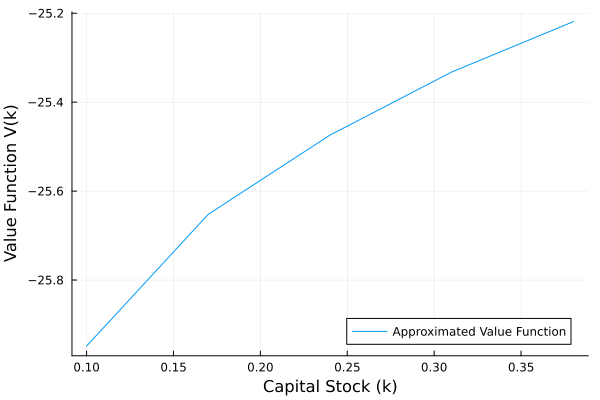

In [12]:

plot(k_grid, V, label="Approximated Value Function", xlabel="Capital Stock (k)", ylabel="Value Function V(k)", legend=:bottomright)

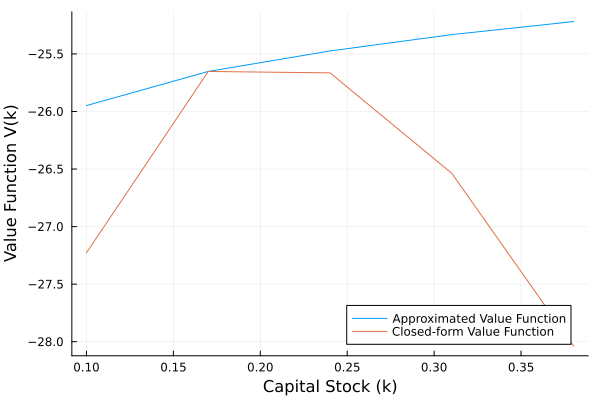

In [13]:
plot!(k_grid, V_real, label="Closed-form Value Function")

In [9]:
using Plots

# Parámetros del modelo
β = 0.96        # Factor de descuento
A = 1.0         # Productividad total de los factores
α = 0.36        # Elasticidad de producción con respecto al capital
δ = 1.0         # Tasa de depreciación

# Capital de estado estacionario
k_star = (β * α * A)^(1 / (1 - α))

# Malla discreta para el capital
k_grid = range(0.1, stop=2*k_star, length=5)  # Malla pequeña alrededor de k*
n = length(k_grid)

# Inicialización de la función de valor y la función de política
V = zeros(n)  # Función de valor inicializada a cero
g = zeros(n)  # Función de política inicializada a cero

# Iteración de la función de valor
tol = 1e-5         # Tolerancia para la convergencia
max_iter = 1000    # Número máximo de iteraciones

for iter in 1:max_iter
    V_new = copy(V)  # Copia de la función de valor para actualizarla
    
    for i in 1:n
        k = k_grid[i]
        value = -Inf  # Valor inicial muy bajo
        
        for j in 1:n
            k_next = k_grid[j]
            c = A * k^α - k_next  # Consumo sin δ ya que δ = 1
            
            if c > 0  # Solo consideramos consumo positivo
                v = log(c) + β * V[j]  # Valor de la función objetivo
                if v > value  # Maximizar la función objetivo
                    value = v
                    g[i] = k_next  # Actualizar la función de política
                end
            end
        end
        
        V_new[i] = value  # Actualizar la función de valor
    end
    
    # Verificación de convergencia
    if maximum(abs.(V_new - V)) < tol
        println("Converged after $iter iterations")
        break
    end
    
    V = V_new  # Actualizar la función de valor para la próxima iteración
end

# Regla de decisión teórica
g_theoretical(k) = β * α * A * k^α

# Gráfica de las reglas de decisión
plot(k_grid, g, label="Approximated Decision Rule g(k)", xlabel="Capital Stock (k)", ylabel="Next Period Capital Stock (k')", legend=:bottomright)
plot!(k_grid, g_theoretical.(k_grid), label="Theoretical Decision Rule g(k)")

# Mostrar la gráfica
display(plot!)




plot! (generic function with 4 methods)

Converged after 284 iterations


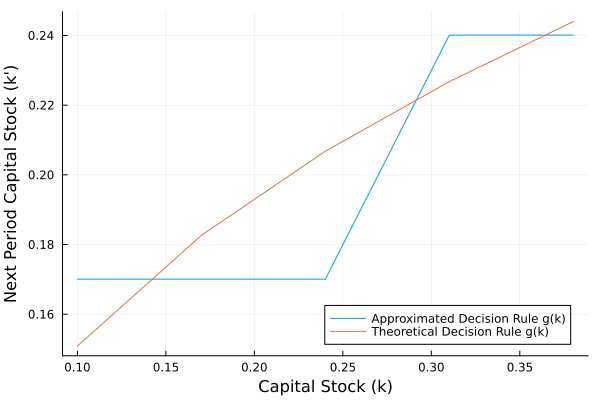

In [10]:
plot(k_grid, g, label="Approximated Decision Rule g(k)", xlabel="Capital Stock (k)", ylabel="Next Period Capital Stock (k')", legend=:bottomright)
plot!(k_grid, g_theoretical.(k_grid), label="Theoretical Decision Rule g(k)")

La principal razón por la cual la función de política es a menudo más fácil de aproximar es que una vez que tenemos la función de valor, calcular la política óptima es una tarea directa de maximización. La función de valor, por otro lado, requiere resolver un problema de optimización iterativo completo para cada punto, lo cual es computacionalmente más intensivo y complejo.

# C)

Converged


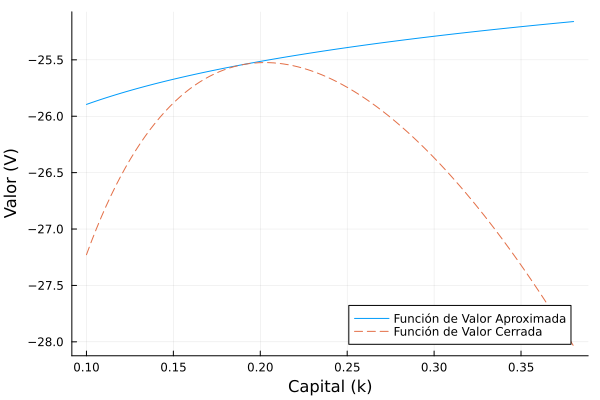

In [14]:
using Plots

# Parámetros del modelo
β = 0.96           # Factor de descuento
A = 1.0            # Productividad total de los factores
α = 0.36           # Elasticidad de producción con respecto al capital
k_star = (β * A * α)^(1 / (1 - α))  # Capital de estado estacionario
k0 = 0.3 * k_star  # Capital inicial

# Malla discreta para el capital (más densa)
k_grid = range(0.1, stop=2*k_star, length=100)  # Aumentar la densidad de la malla
n = length(k_grid)

# Inicialización de la función de valor y la función de política
V = zeros(n)  # Función de valor inicializada a cero
g = zeros(n)  # Función de política inicializada a cero

# Iteración de la función de valor
tol = 1e-5         # Tolerancia para la convergencia
max_iter = 1000    # Número máximo de iteraciones

for iter in 1:max_iter
    V_new = copy(V)  # Copia de la función de valor para actualizarla
    
    for i in 1:n
        k = k_grid[i]
        value = -Inf  # Valor inicial muy bajo
        
        for j in 1:n
            k_next = k_grid[j]
            c = A * k^α - k_next  # Consumo
            
            if c > 0  # Solo consideramos consumo positivo
                v = log(c) + β * V[j]  # Valor de la función objetivo
                if v > value  # Maximizar la función objetivo
                    value = v
                    g[i] = k_next  # Actualizar la función de política
                end
            end
        end
        
        V_new[i] = value  # Actualizar la función de valor
    end
    
    # Verificación de convergencia
    if maximum(abs.(V_new - V)) < tol
        println("Converged")
        break
    end
    
    V = V_new  # Actualizar la función de valor para la próxima iteración
end

# Calcular la función de valor en forma cerrada
function V_closed(k)
    c = A * k^α - k
    return log(c) / (1 - β)
end

# Función de valor en forma cerrada para la malla de capital
V_real = [V_closed(k) for k in k_grid]

# Graficar los resultados
plot(k_grid, V, label="Función de Valor Aproximada", xlabel="Capital (k)", ylabel="Valor (V)", legend=:bottomright)
plot!(k_grid, V_real, label="Función de Valor Cerrada", linestyle=:dash)


Converged after 284 iterations


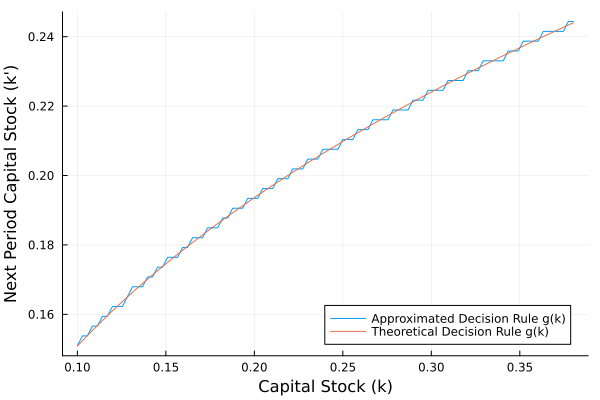

In [16]:
using Plots

# Parámetros del modelo
β = 0.96        # Factor de descuento
A = 1.0         # Productividad total de los factores
α = 0.36        # Elasticidad de producción con respecto al capital
δ = 1.0         # Tasa de depreciación

# Capital de estado estacionario
k_star = (β * α * A)^(1 / (1 - α))

# Malla discreta para el capital (más densa)
k_grid = range(0.1, stop=2*k_star, length=100)  # Aumentar la densidad de la malla
n = length(k_grid)

# Inicialización de la función de valor y la función de política
V = zeros(n)  # Función de valor inicializada a cero
g = zeros(n)  # Función de política inicializada a cero

# Iteración de la función de valor
tol = 1e-5         # Tolerancia para la convergencia
max_iter = 1000    # Número máximo de iteraciones

for iter in 1:max_iter
    V_new = copy(V)  # Copia de la función de valor para actualizarla
    
    for i in 1:n
        k = k_grid[i]
        value = -Inf  # Valor inicial muy bajo
        
        for j in 1:n
            k_next = k_grid[j]
            c = A * k^α - k_next  # Consumo sin δ ya que δ = 1
            
            if c > 0  # Solo consideramos consumo positivo
                v = log(c) + β * V[j]  # Valor de la función objetivo
                if v > value  # Maximizar la función objetivo
                    value = v
                    g[i] = k_next  # Actualizar la función de política
                end
            end
        end
        
        V_new[i] = value  # Actualizar la función de valor
    end
    
    # Verificación de convergencia
    if maximum(abs.(V_new - V)) < tol
        println("Converged after $iter iterations")
        break
    end
    
    V = V_new  # Actualizar la función de valor para la próxima iteración
end

# Regla de decisión teórica
g_theoretical(k) = β * α * A * k^α

# Graficar las reglas de decisión
plot(k_grid, g, label="Regla de Decisión Aproximada g(k)", xlabel="Stock de Capital (k)", ylabel="Stock de Capital en el Próximo Período (k')", legend=:bottomright)
plot!(k_grid, g_theoretical.(k_grid), label="Regla de Decisión Teórica g(k)", linestyle=:dash)


plot(k_grid, g, label="Approximated Decision Rule g(k)", xlabel="Capital Stock (k)", ylabel="Next Period Capital Stock (k')", legend=:bottomright)
plot!(k_grid, g_theoretical.(k_grid), label="Theoretical Decision Rule g(k)")

Podemos ver que a medida que aumentan las iteraciones la fucion de política pasa a aproximarse con gran exactitud, mientras que no se logra una mejora significativa en las prediciones de la función de valor.

# D)

Converged
El valor de k_star es 8.184978407907066


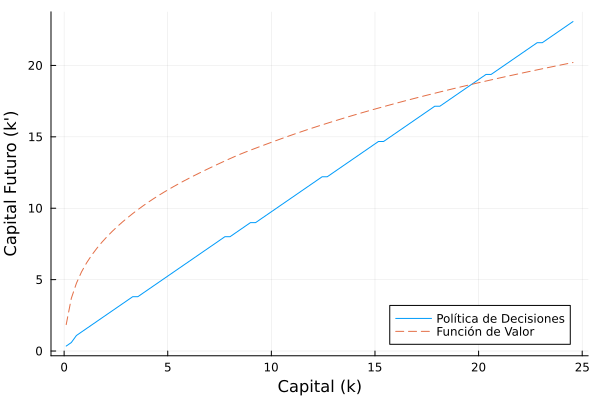

In [44]:
using Plots

# Parámetros del modelo (repetidos aquí para referencia)
β = 0.96  # Factor de descuento
δ = 0.05  # Tasa de depreciación
A = 1.0  # Productividad total de los factores
α = 0.36  # Elasticidad de producción con respecto al capital
k_star = ((β * A * α) / (1 - β + δ))^(1 / (1 - α))  # Capital de estado estacionario
k0 = 0.3 * k_star  # Capital inicial

# Malla discreta para el capital
k_grid = range(0.1, stop=3*k_star, length=100) 
n = length(k_grid)  # Número de puntos en la malla de capital

# Inicialización de la función de valor y la función de política
V = zeros(n)  # Función de valor inicial
g = zeros(n)  # Función de política inicial

# Iteración de la función de valor
tol = 1e-5  # Tolerancia para la convergencia
max_iter = 1000  # Número máximo de iteraciones

for iter in 1:max_iter
    V_new = copy(V)  # Copia de la función de valor para la actualización
    
    for i in 1:n
        k = k_grid[i]  # Capital actual
        value = -Inf  # Valor inicial
        
        for j in 1:n
            k_next = k_grid[j]  # Capital futuro
            # Cálculo del consumo
            c = A * k^α - k_next + (1 - δ) * k
            
            if c > 0  # Verifica si el consumo es positivo
                # Cálculo del valor presente
                v = log(c) + β * V[j]
                if v > value  # Actualiza el valor si es mayor
                    value = v
                    g[i] = k_next  # Actualiza la política óptima
                end
            end
        end
        
        V_new[i] = value  # Actualiza la función de valor
    end
    
    # Verifica si la función de valor ha convergido
    if maximum(abs.(V_new - V)) < tol
        println("Converged")
        break
    end
    
    V = V_new  # Actualiza la función de valor para la siguiente iteración
end

println("El valor de k_star es $k_star")  # Muestra el valor del capital de estado estacionario

# Graficar la política de decisiones y la función de valor
plot(k_grid, g, label="Política de Decisiones", xlabel="Capital (k)", ylabel="Capital Futuro (k')", legend=:bottomright)
plot!(k_grid, V, label="Función de Valor", linestyle=:dash)


Cuando la depreciación no es completa, la función de valor y las reglas de decisión reflejan el valor adicional del capital que se conserva en el tiempo. La función de valor será más alta y la política de decisión será más conservadora en comparación con el caso de depreciación completa. Esta diferencia surge porque los agentes valoran más el capital que se conserva y tienden a ajustar sus decisiones de inversión y consumo en consecuencia.